## Validating results using CCLE data

**Input:**  
- CCLE transcriptomics, protein expression data (RPPA) and proteomics (MS) data from depmap.org
- CCLE antibody validation status information 

**Output:** 
- Figure 4

### Import Packages

In [1]:
import os, re
import numpy as np
import pandas as pd
import seaborn as sns

import graphing_utils
import customized_plot 
import standardised_pipeline_utils
%matplotlib inline
from matplotlib import pyplot as plt

In [2]:
get_data_path = lambda folders, fname: os.path.normpath(os.environ['DATA_PATH']+'/'+'/'.join(folders) +'/'+ fname)
get_table_path = lambda fname: os.path.normpath('../tables/' + fname)
get_figure_path = lambda fname: os.path.normpath('../figures/' + fname)

In [3]:
file_ccle_transcriptomics = get_data_path(['depmap','20Q4'], 'CCLE_expression.csv')
file_ccle_proteomics = get_data_path(['nusinow_2020'], 'Table_S2.xlsx')
file_ccle_rppa = get_data_path(['depmap', 'ProteinArray_RPPA'], "CCLE_RPPA_20180123.csv")

file_ccle_sample_info = get_data_path(['depmap','20Q4'], 'sample_info.csv')
file_ccle_antibody = get_data_path(['depmap', 'ProteinArray_RPPA'], 'CCLE_RPPA_Ab_info_20180123.csv')
file_sourceData_Figure4 = get_table_path('SourceDataForFigure4.csv')

### Load Data

In [4]:
ccle_antibody = pd.read_csv(file_ccle_antibody, usecols=['Antibody_Name', 'Target_Genes', 'Validation_Status'])
ccle_antibody[:2]

,Antibody_Name,Target_Genes,Validation_Status
0,14-3-3_beta,YWHAB,Validated
1,14-3-3_epsilon_Caution,YWHAE,Caution


In [5]:
# Process antibody 
ccle_antibody = ccle_antibody[~ccle_antibody['Antibody_Name'].str.contains('_p', regex=False)]

In [6]:
def get_mapping_to_1_gene(name):
    parts = name.split(' ')
    if((len(parts) == 1) & (re.search('([0-9]+-[0-9]+)$', parts[0]) is None)):
        return(parts)
    else:
        return(np.nan)

In [7]:
ccle_antibody['GeneSymbol'] = ccle_antibody['Target_Genes'].apply(lambda x: get_mapping_to_1_gene(x))
#antibody_status_subset['GeneName'].str.split(',')

In [8]:
ccle_antibody['Target_Genes'].isnull().sum()

0

In [9]:
ccle_antibody.dropna(subset=['Target_Genes'], inplace=True)
ccle_antibody = ccle_antibody.replace('Validated', 'Valid').rename(columns={'Validation_Status': 'ValidationStatus'})
print('Dimensions', ccle_antibody.shape)
ccle_antibody['ValidationStatus'].value_counts()

Dimensions (159, 4)


Valid      100
Caution     59
Name: ValidationStatus, dtype: int64

In [10]:
ccle_antibody['ValidationStatus'].value_counts(normalize=True)

Valid      0.628931
Caution    0.371069
Name: ValidationStatus, dtype: float64

In [11]:
ccle_antibody = ccle_antibody.set_index('Target_Genes')
ccle_antibody.loc[ccle_antibody[ccle_antibody.index.duplicated()].index]
ccle_antibody = ccle_antibody[~ccle_antibody.index.duplicated(keep='first')]
ccle_antibody.shape

(155, 3)

#### RPPA

In [12]:
ccle_protein_rppa = pd.read_csv(file_ccle_rppa, index_col=0).T
print("Dimensions after dropping rows with >20% null values: ", ccle_protein_rppa.shape)
ccle_protein_rppa[:2]

Dimensions after dropping rows with >20% null values:  (214, 899)


,DMS53_LUNG,SW1116_LARGE_INTESTINE,NCIH1694_LUNG,P3HR1_HAEMATOPOIETIC_AND_LYMPHOID_TISSUE,HUT78_HAEMATOPOIETIC_AND_LYMPHOID_TISSUE,UMUC3_URINARY_TRACT,HOS_BONE,HUNS1_HAEMATOPOIETIC_AND_LYMPHOID_TISSUE,AML193_HAEMATOPOIETIC_AND_LYMPHOID_TISSUE,RVH421_SKIN,...,NCIH2073_LUNG,MOLT3_HAEMATOPOIETIC_AND_LYMPHOID_TISSUE,HOP62_LUNG,EKVX_LUNG,OVCAR5_OVARY,UO31_KIDNEY,SF268_CENTRAL_NERVOUS_SYSTEM,SF539_CENTRAL_NERVOUS_SYSTEM,SNB75_CENTRAL_NERVOUS_SYSTEM,HOP92_LUNG
14-3-3_beta,-0.104888,0.358504,0.028738,0.120039,-0.268997,-0.171170,-0.025261,-0.169773,0.081936,0.221993,...,-0.13152,-0.264095,-0.126198,-0.054609,-0.207196,0.043231,-0.034597,-0.250998,-0.139833,0.057413
14-3-3_epsilon_Caution,0.060414,-0.180291,0.071902,-0.066802,-0.060281,0.055813,0.008353,-0.163311,-0.170779,0.139321,...,0.05746,0.155753,-0.155557,-0.233718,-0.021296,0.093158,0.065964,0.420490,0.194831,-0.069547


In [13]:
data = ccle_protein_rppa.reset_index()
data = data[data['index'].str.contains("_p") == False]
data['index'] = data['index'].map(dict(zip(ccle_antibody['Antibody_Name'], ccle_antibody.index)))
data.dropna(subset = ['index'], inplace=True)
data_gene_symbols = data['index'].apply(lambda x: pd.Series(x.split(' ')))
    # discarding proteins expression where the antibody may bind to more than 1 target
index_to_discard = list(data_gene_symbols[~data_gene_symbols[1].isnull()].index)
data = data.drop(index = index_to_discard)
print("Dimensions: ", data.shape)

data = data.loc[data.index.drop_duplicates(keep='first')].set_index('index')
ccle_protein_rppa = data.dropna(thresh=(0.8*len(data.columns)))
ccle_protein_rppa_processed = standardised_pipeline_utils.process(ccle_protein_rppa)
print("Dimensions: ", ccle_protein_rppa_processed.shape)
ccle_protein_rppa_processed[:2]

Dimensions:  (152, 900)
Dimensions:  (152, 899)
Dimensions:  (152, 899)


,DMS53_LUNG,SW1116_LARGE_INTESTINE,NCIH1694_LUNG,P3HR1_HAEMATOPOIETIC_AND_LYMPHOID_TISSUE,HUT78_HAEMATOPOIETIC_AND_LYMPHOID_TISSUE,UMUC3_URINARY_TRACT,HOS_BONE,HUNS1_HAEMATOPOIETIC_AND_LYMPHOID_TISSUE,AML193_HAEMATOPOIETIC_AND_LYMPHOID_TISSUE,RVH421_SKIN,...,NCIH2073_LUNG,MOLT3_HAEMATOPOIETIC_AND_LYMPHOID_TISSUE,HOP62_LUNG,EKVX_LUNG,OVCAR5_OVARY,UO31_KIDNEY,SF268_CENTRAL_NERVOUS_SYSTEM,SF539_CENTRAL_NERVOUS_SYSTEM,SNB75_CENTRAL_NERVOUS_SYSTEM,HOP92_LUNG
index,,,,,,,,,,,,,,,,,,,,,
ACACA,0.145489,-0.647232,0.731379,0.148369,-0.245375,0.037885,-0.028906,-0.479745,0.964608,0.685739,...,-0.050433,-0.734374,1.239161,0.346927,0.272580,0.800856,-0.124741,-0.071125,-0.217065,-0.315348
ACTB,-0.851057,1.636039,0.870009,-0.140614,-1.754644,-0.993305,-0.149776,1.161453,-0.273803,-0.629649,...,-0.712990,-0.718007,0.689550,-0.056389,0.224697,0.096702,0.157523,1.615186,0.474055,0.428906


In [14]:
ccle_sample_info = pd.read_csv(file_ccle_sample_info)
print("Dimensions: ", ccle_sample_info.shape)
ccle_sample_info[:2]

Dimensions:  (1812, 26)


,DepMap_ID,cell_line_name,stripped_cell_line_name,CCLE_Name,alias,COSMICID,sex,source,Achilles_n_replicates,cell_line_NNMD,...,primary_or_metastasis,primary_disease,Subtype,age,Sanger_Model_ID,depmap_public_comments,lineage,lineage_subtype,lineage_sub_subtype,lineage_molecular_subtype
0,ACH-000001,NIH:OVCAR-3,NIHOVCAR3,NIHOVCAR3_OVARY,OVCAR3,905933.0,Female,ATCC,NaN,NaN,...,Metastasis,Ovarian Cancer,"Adenocarcinoma, high grade serous",60.0,SIDM00105,NaN,ovary,ovary_adenocarcinoma,high_grade_serous,NaN
1,ACH-000002,HL-60,HL60,HL60_HAEMATOPOIETIC_AND_LYMPHOID_TISSUE,NaN,905938.0,Female,ATCC,NaN,NaN,...,Primary,Leukemia,"Acute Myelogenous Leukemia (AML), M3 (Promyelo...",35.0,SIDM00829,NaN,blood,AML,M3,NaN


#### Transcriptomics

In [15]:
ccle_transcriptomics = pd.read_csv(file_ccle_transcriptomics, index_col=0)
print("Dimensions: ", ccle_transcriptomics.shape)
ccle_transcriptomics[:2]

Dimensions:  (1376, 19182)


,TSPAN6 (7105),TNMD (64102),DPM1 (8813),SCYL3 (57147),C1orf112 (55732),FGR (2268),CFH (3075),FUCA2 (2519),GCLC (2729),NFYA (4800),...,AC090517.4 (54816),AL160269.1 (11046),ABCF2-H2BE1 (114483834),FO393400.1 (149951),POLR2J3 (548644),H2BE1 (114483833),AL445238.1 (647264),GET1-SH3BGR (106865373),AC024598.1 (22891),AC113348.1 (102724657)
ACH-001113,4.990501,0.000000,7.273702,2.765535,4.480265,0.028569,1.269033,3.058316,6.483171,5.05398,...,0.111031,0.15056,1.427606,0.042644,5.781884,0.0,0.0,0.799087,0.014355,0.000000
ACH-001289,5.209843,0.545968,7.070604,2.538538,3.510962,0.000000,0.176323,3.836934,4.200850,3.83289,...,0.310340,0.00000,0.807355,0.000000,4.704319,0.0,0.0,0.464668,0.000000,0.070389


In [16]:
# Rename the cell lines given as DepMap ID to CCLE_Name and columns to just contain the hgnc_symbol
ccle_transcriptomics = ccle_transcriptomics.rename(index = dict(zip(ccle_sample_info['DepMap_ID'], 
                                                                    ccle_sample_info['CCLE_Name'])),
                                                   columns = lambda x : str(x).split(' ')[0])
# Transpose to obtain a matrix similar to other studies
ccle_transcriptomics = ccle_transcriptomics.transpose()
ccle_transcriptomics[:2]

,LC1SQSF_LUNG,COGAR359_SOFT_TISSUE,COLO794_SKIN,KKU213_BILIARY_TRACT,RT4_URINARY_TRACT,SNU283_LARGE_INTESTINE,NCIH1395_LUNG,DEL_HAEMATOPOIETIC_AND_LYMPHOID_TISSUE,SNU1196_BILIARY_TRACT,LC1F_LUNG,...,BL70_HAEMATOPOIETIC_AND_LYMPHOID_TISSUE,U343_CENTRAL_NERVOUS_SYSTEM,639V_URINARY_TRACT,MON_SOFT_TISSUE,LOXIMVI_SKIN,TOLEDO_HAEMATOPOIETIC_AND_LYMPHOID_TISSUE,SSP25_BILIARY_TRACT,ECC2_BILIARY_TRACT,A673_BONE,TT_OESOPHAGUS
TSPAN6,4.990501,5.209843,3.77926,5.726831,7.465648,4.914086,4.032982,0.097611,4.712596,5.101398,...,0.070389,4.69265,5.0268,6.699052,4.173127,0.097611,5.045268,5.805292,4.870858,5.117695
TNMD,0.000000,0.545968,0.00000,0.000000,0.000000,0.176323,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.00000,0.0000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000


In [17]:
ccle_transcriptomics_processed = standardised_pipeline_utils.process(ccle_transcriptomics)
ccle_transcriptomics_processed[:2]

Dimensions:  (19180, 1376)


,LC1SQSF_LUNG,COGAR359_SOFT_TISSUE,COLO794_SKIN,KKU213_BILIARY_TRACT,RT4_URINARY_TRACT,SNU283_LARGE_INTESTINE,NCIH1395_LUNG,DEL_HAEMATOPOIETIC_AND_LYMPHOID_TISSUE,SNU1196_BILIARY_TRACT,LC1F_LUNG,...,BL70_HAEMATOPOIETIC_AND_LYMPHOID_TISSUE,U343_CENTRAL_NERVOUS_SYSTEM,639V_URINARY_TRACT,MON_SOFT_TISSUE,LOXIMVI_SKIN,TOLEDO_HAEMATOPOIETIC_AND_LYMPHOID_TISSUE,SSP25_BILIARY_TRACT,ECC2_BILIARY_TRACT,A673_BONE,TT_OESOPHAGUS
A1BG,3.976364,2.134221,2.650765,0.0,0.111031,0.226509,0.097611,5.276869,0.111031,2.871844,...,3.854993,2.570463,4.990955,4.296457,0.000000,4.874797,0.189034,0.0,4.878235,2.650765
A1CF,0.014355,0.000000,0.000000,0.0,0.028569,1.673556,0.757023,0.028569,0.056584,0.014355,...,0.000000,0.097611,0.000000,0.000000,0.028569,0.014355,0.056584,0.0,0.000000,0.042644


#### Mass spectrometry based proteomics 

In [18]:
ccle_proteomics = pd.read_excel(io=file_ccle_proteomics, sheet_name="Normalized Protein Expression", engine='openpyxl', 
                                usecols="A:PJ")
print("Dimensions: ", ccle_proteomics.shape)
ccle_proteomics[:2]

Dimensions:  (12755, 426)


,Protein_Id,Gene_Symbol,Description,Group_ID,Uniprot,Uniprot_Acc,TenPx01_Peptides,TenPx02_Peptides,TenPx03_Peptides,TenPx04_Peptides,...,NCIH2030_LUNG_TenPx18,22RV1_PROSTATE_TenPx24,A172_CENTRAL_NERVOUS_SYSTEM_TenPx24,BT20_BREAST_TenPx24,CALU6_LUNG_TenPx24,FADU_UPPER_AERODIGESTIVE_TRACT_TenPx24,KP4_PANCREAS_TenPx24,MONOMAC6_HAEMATOPOIETIC_AND_LYMPHOID_TISSUE_TenPx24,OVCAR8_OVARY_TenPx24,THP1_HAEMATOPOIETIC_AND_LYMPHOID_TISSUE_TenPx24
0,sp|P55011|S12A2_HUMAN,SLC12A2,S12A2_HUMAN Solute carrier family 12 member 2,0,S12A2_HUMAN,P55011,41,16,23,59,...,-1.345024,1.811205,-0.921176,-1.045727,0.845574,-0.071063,0.702306,-1.395878,-1.165032,-0.547536
1,sp|P35453|HXD13_HUMAN,HOXD13,HXD13_HUMAN Homeobox protein Hox-D13,1,HXD13_HUMAN,P35453,0,0,0,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [19]:
ccle_proteomics.set_index('Gene_Symbol', inplace=True)
ccle_proteomics = ccle_proteomics.loc[:, ccle_proteomics.columns.str.contains('_TenPx')]

In [20]:
# Eliminating the cell lines that do not correlate well with transcriptomics data as mentioned in the paper 
ccle_proteomics.drop(columns=['SW948_LARGE_INTESTINE_TenPx11', 'CAL120_BREAST_TenPx02', 'HCT15_LARGE_INTESTINE_TenPx30'], 
                    inplace=True)
ccle_proteomics = ccle_proteomics.rename(columns = lambda x : str(x).split('_TenPx')[0])

In [21]:
ccle_proteomics_processed = standardised_pipeline_utils.process(ccle_proteomics)
ccle_proteomics_processed[:2]

Dimensions:  (7372, 375)


,MDAMB468_BREAST,SH4_SKIN,AU565_BREAST,KMRC1_KIDNEY,CAL51_BREAST,RPMI7951_SKIN,RERFLCMS_LUNG,IGR37_SKIN,VMRCRCW_KIDNEY,HEP3B217_LIVER,...,NCIH2030_LUNG,22RV1_PROSTATE,A172_CENTRAL_NERVOUS_SYSTEM,BT20_BREAST,CALU6_LUNG,FADU_UPPER_AERODIGESTIVE_TRACT,KP4_PANCREAS,MONOMAC6_HAEMATOPOIETIC_AND_LYMPHOID_TISSUE,OVCAR8_OVARY,THP1_HAEMATOPOIETIC_AND_LYMPHOID_TISSUE
Gene_Symbol,,,,,,,,,,,,,,,,,,,,,
A2M,-0.345562,1.642186,-1.129114,1.493333,0.274652,-0.615667,-0.957249,-0.174494,-0.987932,1.513325,...,-0.981657,-0.921538,3.905544,-0.649348,-1.055916,-1.116991,1.922976,-1.106344,-0.770372,-1.342713
AAAS,-0.109405,-0.283335,0.024663,-0.588886,0.673324,0.010466,0.474615,0.037159,-0.362833,-0.225824,...,-0.093176,-0.518686,-0.642067,-0.188224,-0.259101,-0.779655,-0.628770,1.205109,-0.584588,1.622359


In [22]:
common_cell_lines = np.intersect1d(np.intersect1d(ccle_transcriptomics_processed.columns, ccle_protein_rppa_processed.columns), 
                                   ccle_proteomics_processed.columns)
ccle_transcriptomics_processed = ccle_transcriptomics_processed.reindex(common_cell_lines, axis=1)
ccle_proteomics_processed = ccle_proteomics_processed.reindex(common_cell_lines, axis=1)
ccle_protein_rppa_processed = ccle_protein_rppa_processed.reindex(common_cell_lines, axis=1)

In [23]:
ccle_transcriptomics_processed, ccle_protein_rppa_processed_subset =  standardised_pipeline_utils.match_proteins_samples( \
                                                                                ccle_transcriptomics_processed, 
                                                                                ccle_protein_rppa_processed)
correlation_ccle_rppa = standardised_pipeline_utils.correlate_genewise(ccle_transcriptomics_processed, 
                                                                       ccle_protein_rppa_processed_subset, 
                                                                       'mRNA_RPPA_cor')
print("Dimensions: ", correlation_ccle_rppa.shape)
correlation_ccle_rppa[:2]

Number of common proteins:  150
Number of common samples:  359
Median Spearman Correlation:  0.4964
Dimensions:  (150, 1)


,mRNA_RPPA_cor
ACACA,0.566263
ACTB,0.386765


In [24]:
# reuse the transcriptomics data used to check for common cell lines and proteins with rppa data 
ccle_transcriptomics_processed, ccle_proteomics_processed_subset =  standardised_pipeline_utils.match_proteins_samples( \
                                                                                ccle_transcriptomics_processed, 
                                                                                ccle_proteomics_processed)

correlation_ccle_ms = standardised_pipeline_utils.correlate_genewise(ccle_transcriptomics_processed, 
                                                                     ccle_proteomics_processed_subset, 'mRNA_MS_cor')
correlation_ccle_ms[:2]

Number of common proteins:  123
Number of common samples:  359
Median Spearman Correlation:  0.4814


,mRNA_MS_cor
ACACA,0.371653
ACTB,0.481398


In [25]:
combined_ccle_cor_status = pd.concat([correlation_ccle_rppa, correlation_ccle_ms, ccle_antibody], 
                                     join='inner', axis=1).drop(columns=['Antibody_Name', 'GeneSymbol'])
print("Dimensions: ", combined_ccle_cor_status.shape)
combined_ccle_cor_status[:2]

Dimensions:  (123, 3)


,mRNA_RPPA_cor,mRNA_MS_cor,ValidationStatus
ACACA,0.566263,0.371653,Caution
ACTB,0.386765,0.481398,Caution


In [26]:
palette = [graphing_utils.get_color(color) for color in ['orange', 'green']]
xlab = 'Antibody validation status'; ylab1 = "mRNA-protein (RPPA) correlation"; ylab2 = "mRNA-protein (MS) correlation"
args = [graphing_utils.additional_plot_parameters(xlab="Percentage", ylab="Validation Status",
                                                             palette = palette),
        graphing_utils.additional_plot_parameters(xlab=xlab, ylab=ylab1, palette = palette[::len(palette)-1]), 
        graphing_utils.additional_plot_parameters(xlab=xlab, ylab=ylab2, palette = palette[::len(palette)-1]), 
        graphing_utils.additional_plot_parameters(xlab=xlab, ylab="protein (RPPA) - protein (MS)\ncorrelation", 
                                                  palette = palette[::len(palette)-1])]

In [27]:
combined_ccle_cor_status.replace('Caution', 'Use with Caution', inplace=True)
combined_ccle_cor_status['ValidationStatus'].value_counts()

Valid               76
Use with Caution    47
Name: ValidationStatus, dtype: int64

In [28]:
# combined_ccle_cor_status.to_csv(file_sourceData_Figure4)

ccle_antibody['ValidationStatus'].value_counts(normalize=True)*100

Valid      61.935484
Caution    38.064516
Name: ValidationStatus, dtype: float64

In [29]:
# reuse the transcriptomics data used to check for common cell lines and proteins with rppa data 
ccle_protein_rppa_processed_subset, ccle_proteomics_processed_subset =  standardised_pipeline_utils.match_proteins_samples( \
                                                                                ccle_protein_rppa_processed, 
                                                                                ccle_proteomics_processed)

correlation_ccle_rppa_ms = standardised_pipeline_utils.correlate_genewise(ccle_protein_rppa_processed_subset, 
                                                                     ccle_proteomics_processed_subset, 'RPPA-MS cor')
correlation_ccle_rppa_ms[:2]

Number of common proteins:  124
Number of common samples:  359
Median Spearman Correlation:  0.4918


,RPPA-MS cor
index,
ACACA,0.518745
ACTB,0.380440


In [30]:
combined_protein_cor_status = pd.concat([correlation_ccle_rppa_ms, ccle_antibody], 
                                     join='inner', axis=1).drop(columns=['Antibody_Name', 'GeneSymbol'])
print("Dimensions: ", combined_protein_cor_status.shape)
combined_protein_cor_status[:2]

Dimensions:  (124, 2)


,RPPA-MS cor,ValidationStatus
ACACA,0.518745,Caution
ACTB,0.380440,Caution


In [31]:
combined_protein_cor_status.replace('Caution', 'Use with Caution', inplace=True)
combined_protein_cor_status[:2]

,RPPA-MS cor,ValidationStatus
ACACA,0.518745,Use with Caution
ACTB,0.380440,Use with Caution


In [32]:
ccle_antibody.replace('Caution', 'Use with Caution', inplace=True)

p-value annotation legend:
ns: 5.00e-02 < p <= 1.00e+00
*: 1.00e-02 < p <= 5.00e-02
**: 1.00e-03 < p <= 1.00e-02
***: 1.00e-04 < p <= 1.00e-03
****: p <= 1.00e-04

Use with Caution v.s. Valid: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val=1.475e-02 U_stat=1.317e+03
p-value annotation legend:
ns: 5.00e-02 < p <= 1.00e+00
*: 1.00e-02 < p <= 5.00e-02
**: 1.00e-03 < p <= 1.00e-02
***: 1.00e-04 < p <= 1.00e-03
****: p <= 1.00e-04

Use with Caution v.s. Valid: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val=7.379e-02 U_stat=1.442e+03
p-value annotation legend:
ns: 5.00e-02 < p <= 1.00e+00
*: 1.00e-02 < p <= 5.00e-02
**: 1.00e-03 < p <= 1.00e-02
***: 1.00e-04 < p <= 1.00e-03
****: p <= 1.00e-04

Use with Caution v.s. Valid: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val=5.920e-03 U_stat=1.287e+03


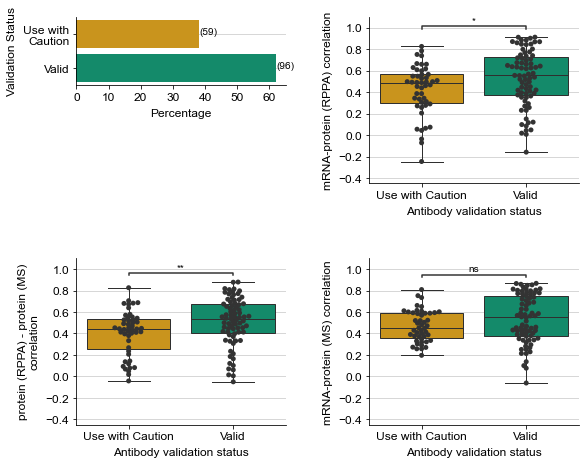

In [33]:
inner = [['innerA'],
         ['innerB']]
outer = [[inner, 'upper right'],
          ['lower left', 'lower right']]

order=['Use with Caution', 'Valid']
with plt.rc_context({'axes.linewidth': 0.8, 'axes.labelsize':12, 'axes.spines.left': True, 'xtick.labelsize':12, 
                     'ytick.labelsize':12}):
    figure, ax = plt.subplot_mosaic(outer, figsize=(9,7.5))
    customized_plot.draw_countplot(ccle_antibody, ax['innerA'], args[0])
    ax['innerB'].axis('off'); 
    customized_plot.draw_swarmBoxPlot(combined_ccle_cor_status, 'mRNA_RPPA_cor', ax['upper right'], args[1], order)
    customized_plot.draw_swarmBoxPlot(combined_ccle_cor_status, 'mRNA_MS_cor', ax['lower right'], args[2], order)
    customized_plot.draw_swarmBoxPlot(combined_protein_cor_status, 'RPPA-MS cor', ax['lower left'], args[3], order)
    plt.subplots_adjust(wspace=0.4, hspace=0.45)
    figure.savefig(get_figure_path('Figure4.svg'), bbox_inches='tight', dpi=300)

<div class="alert alert-block alert-success">
    mRNA-protein (RPPA) correlation is better explained by antibody validation status compared to mRNA-protein (MS) correlation for CCLE data as well. 
</div>